<a href="https://ai4life-mdc24.grand-challenge.org/ai4life-mdc24/">
    <img src="https://rumc-gcorg-p-public.s3.amazonaws.com/b/756/denoising.x10.jpeg" height="200" />
</a>

# SUPPORT dataset

In [1]:
# Imports necessary to execute the code
from pathlib import Path

import matplotlib.pyplot as plt
import pooch
import tifffile
import numpy as np
from PIL import Image
from careamics import CAREamist
from careamics.config import create_n2v_configuration
from careamics.utils import autocorrelation

# use n2v2
use_n2v2 = False

# folder in which to save all the data
root = Path("support")

## Import the dataset

In [2]:
# download the data using pooch
data_root = root / "data"
dataset_url = "https://zenodo.org/records/10925939/files/noisy.tiff?download=1"

file = pooch.retrieve(
    url=dataset_url,
    known_hash="c09a0748a67a9364f257e0aff9502a283b8794f35381577f5dfea6ac1bd01e03",
    path=data_root,
)

## Visualize data

Image shape: (1001, 1024, 1024)


Text(0.5, 1.0, 'Slice 900')

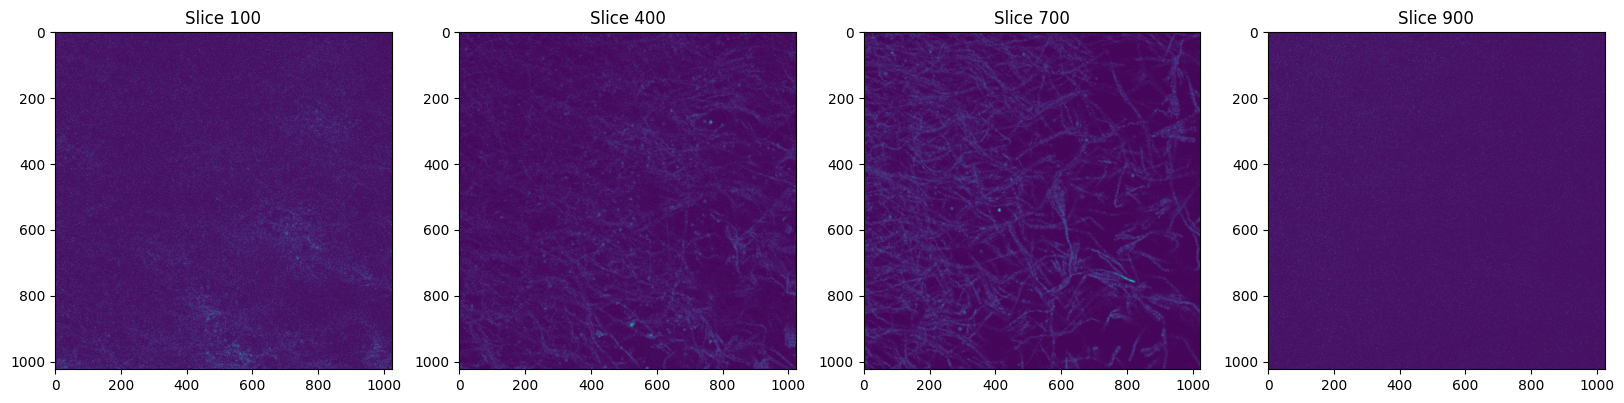

In [3]:
# load training and validation image and show them side by side
train_image = tifffile.imread(file)
print(f"Image shape: {train_image.shape}")

fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax[0].imshow(train_image[100])
ax[0].set_title("Slice 100")
ax[1].imshow(train_image[400])
ax[1].set_title("Slice 400")
ax[2].imshow(train_image[700])
ax[2].set_title("Slice 700")
ax[3].imshow(train_image[900])
ax[3].set_title("Slice 900")

### Compute autocorrelation

Text(0.5, 1.0, 'Autocorrelation')

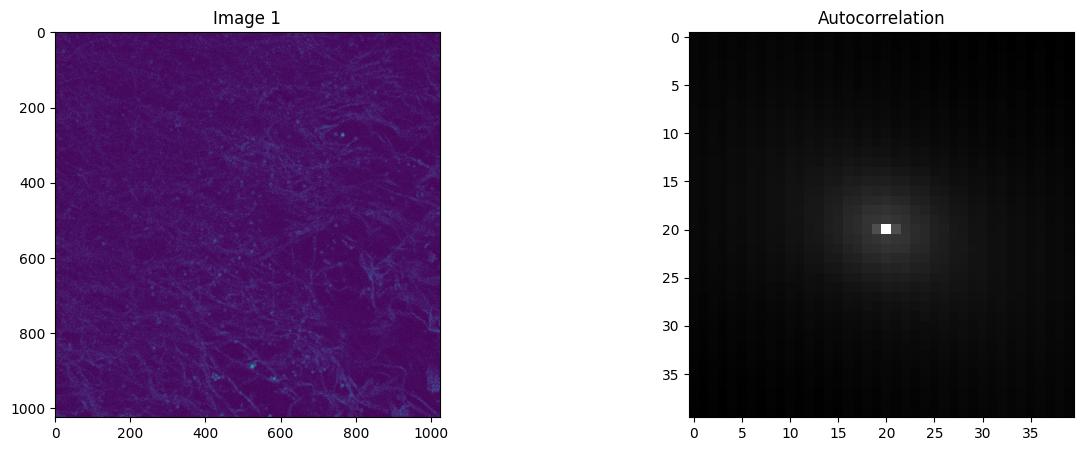

In [4]:
autocorr = autocorrelation(train_image[400])

# crop the correlation around (0, 0)
midpoint = train_image[400].shape[0] // 2
crop_size = 20
slices = (
    slice(midpoint - crop_size, midpoint + crop_size),
    slice(midpoint - crop_size, midpoint + crop_size),
)
# plot autocorrelation
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(train_image[400])
ax[0].set_title("Image 1")
ax[1].imshow(autocorr[slices], cmap="gray")
ax[1].set_title("Autocorrelation")

## Train with CAREamics

### Create configuration


In [5]:
# create configuration
algo = "n2v2" if use_n2v2 else "n2v"

config = create_n2v_configuration(
    experiment_name="support_" + algo,
    data_type="array",
    axes="ZYX",
    patch_size=(16, 64, 64),
    batch_size=2,
    num_epochs=20,
    use_n2v2=use_n2v2,
)

# change augmentations
config.data_config.transforms[0].flip_y = False  # do not flip y
config.data_config.transforms.pop(1)  # remove 90 degree rotations

print(config)

{'algorithm_config': {'algorithm': 'n2v',
                      'loss': 'n2v',
                      'lr_scheduler': {'name': 'ReduceLROnPlateau',
                                       'parameters': {}},
                      'model': {'architecture': 'UNet',
                                'conv_dims': 3,
                                'depth': 2,
                                'final_activation': 'None',
                                'in_channels': 1,
                                'independent_channels': True,
                                'n2v2': False,
                                'num_channels_init': 32,
                                'num_classes': 1},
                      'optimizer': {'name': 'Adam',
                                    'parameters': {'lr': 0.0001}}},
 'data_config': {'axes': 'ZYX',
                 'batch_size': 2,
                 'data_type': 'array',
                 'patch_size': [16, 64, 64],
                 'transforms': [{'flip_x': True,
 

### Train

In [6]:
# instantiate a CAREamist
careamist = CAREamist(
    source=config,
    work_dir=root / algo,
)

# train
careamist.train(
    train_source=train_image,
    val_percentage=0.0,
    val_minimum_split=10,  # use 10 patches as validation
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/localscratch/miniforge3/envs/careamics/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA A40-16Q') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_f

Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/localscratch/miniforge3/envs/careamics/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/localscratch/miniforge3/envs/careamics/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Epoch 0: 100%|███████| 8443/8443 [02:58<00:00, 47.33it/s, train_loss_step=0.772]
Validating: 0it [00:00, ?it/s]
Validation DataLoader 0: 100%|████████████████████| 5/5 [00:00<00:00, 73.84it/s]
Epoch 1: 100%|█| 8443/8443 [03:14<00:00, 43.42it/s, train_loss_step=0.465, val_l
Validating: 0it [00:00, ?it/s]
Validation DataLoader 0: 100%|███████████████████| 5/5 [00:00<00:00, 175.92it/s]
Epoch 2: 100%|█| 8443/8443 [03:37<00:00, 38.83it/s, train_loss_step=0.65, val_lo
Validating: 0it [00:00, ?it/s]
Validation DataLoader 0: 100%|███████████████████| 5/5 [00:00<00:00, 174.91it/s]
Epoch 3: 100%|█| 8443/8443 [03:24<00:00, 41.22it/s, train_loss_step=0.785, val_l
Validating: 0it [00:00, ?it/s]
Validation DataLoader 0: 100%|███████████████████| 5/5 [00:00<00:00, 175.23it/s]
Epoch 4: 100%|█| 8443/8443 [03:15<00:00, 43.21it/s, train_loss_step=0.564, val_l
Validating: 0it [00:00, ?it/s]
Validation DataLoader 0: 100%|███████████████████| 5/5 [00:00<00:00, 184.19it/s]
Epoch 5: 100%|█| 8443/8443 [03:14<0

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|█| 8443/8443 [03:11<00:00, 44.20it/s, train_loss_step=0.564, val_


## Predict 

In [7]:
prediction = careamist.predict(
    source=train_image,
    tile_size=(32, 128, 128),
    tile_overlap=(8, 48, 48),
    batch_size=1,
    tta=False,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/localscratch/miniforge3/envs/careamics/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Predicting: |                                             | 0/? [00:00<?, ?it/s]

### Save predictions

In [8]:
pred_folder = root / ("results_" + algo)
pred_folder.mkdir(exist_ok=True, parents=True)

tifffile.imwrite(pred_folder / "prediction.tiff", prediction[0])

### Visualize the prediction

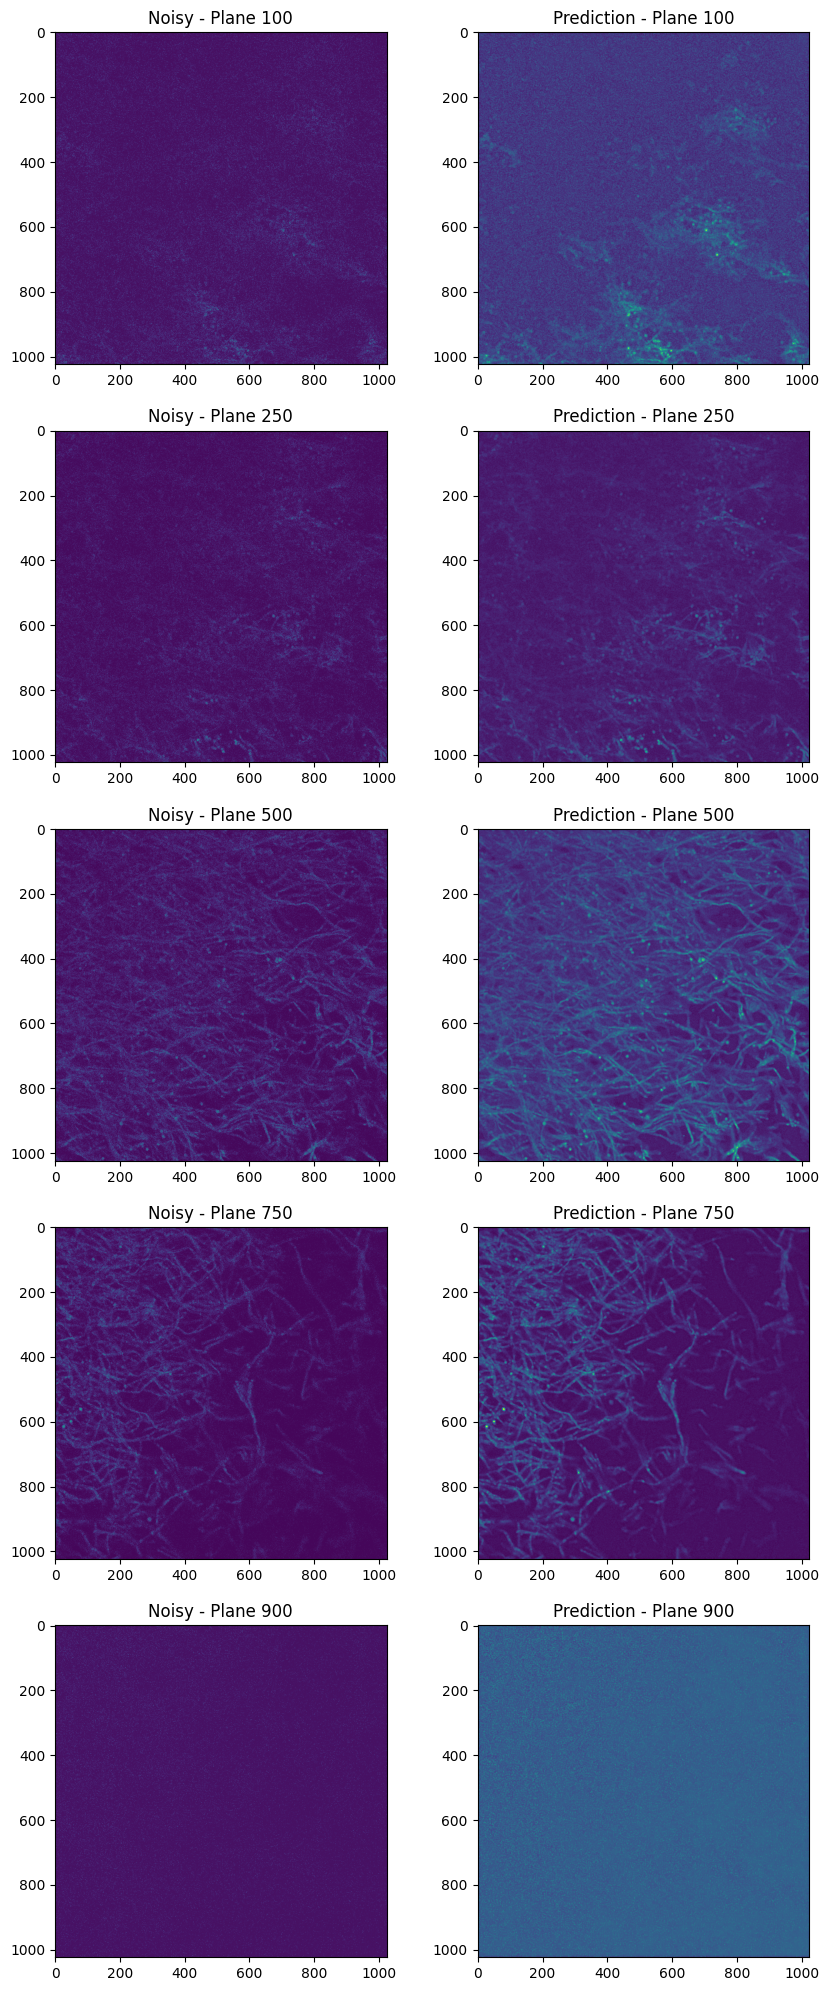

In [9]:
zs = [100, 250, 500, 750, 900]

fig, ax = plt.subplots(len(zs), 2, figsize=(10, 5 * len(zs)))
for i, z in enumerate(zs):
    ax[i, 0].imshow(train_image[z])
    ax[i, 0].set_title(f"Noisy - Plane {z}")

    ax[i, 1].imshow(prediction[0].squeeze()[z])
    ax[i, 1].set_title(f"Prediction - Plane {z}")

## Create cover

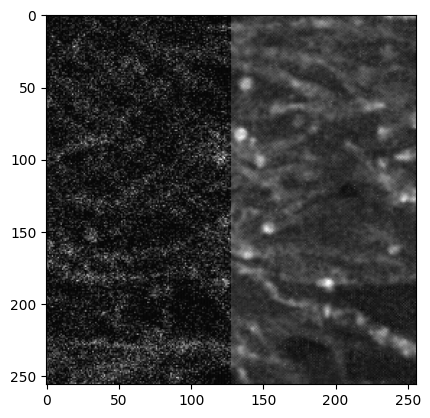

In [10]:
# create a cover image
im_idx = 500
cv_image_noisy = train_image[im_idx]
cv_image_pred = prediction[0].squeeze()[im_idx]

# create image
cover = np.zeros((256, 256))   
(height, width) = cv_image_noisy.shape
assert height > 256
assert width > 256

# normalize train and prediction
norm_noise = (cv_image_noisy - cv_image_noisy.min()) / (cv_image_noisy.max() - cv_image_noisy.min())
norm_pred = (cv_image_pred - cv_image_pred.min()) / (cv_image_pred.max() - cv_image_pred.min())

# fill in halves
cover[:, :256 // 2] = norm_noise[height // 2 - 256 // 2:height // 2 + 256 // 2, width // 2 - 256 // 2:width // 2]
cover[:, 256 // 2:] = norm_pred[height // 2 - 256 // 2:height // 2 + 256 // 2, width // 2:width // 2 + 256 // 2]

# plot the single image
plt.imshow(cover, cmap="gray")

# save the image
im = Image.fromarray(cover * 255)
im = im.convert('L')
im.save("SUPPORT_N2V.jpeg")